In [12]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np

In [13]:
img_shape = (28, 28, 1)
batch_size = 16

latent_dim = 10

In [14]:
# encoder
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [15]:
def sampling(args):
    z_mean, z_log_var = args

    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

In [16]:
# decoder
decoder_input = keras.Input(shape=K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z)

https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
The KL divergence from  y^  to  y  is simply the difference between cross entropy and entropy:

In [17]:
def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(xent_loss + kl_loss)

In [18]:
vae = Model(input_img, z_decoded)

In [19]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

In [20]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [23]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [22]:
vae.fit(x_train, x_train, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 325s 5ms/step - loss: 284661878235.8374 - val_loss: 0.1137
Epoch 2/10
60000/60000 [==============================] - 335s 6ms/step - loss: 0.1110 - val_loss: 0.1052
Epoch 3/10
60000/60000 [==============================] - 332s 6ms/step - loss: 0.1057 - val_loss: 0.1033
Epoch 4/10
60000/60000 [==============================] - 353s 6ms/step - loss: 0.1031 - val_loss: 0.1007
Epoch 5/10
60000/60000 [==============================] - 306s 5ms/step - loss: 0.1015 - val_loss: 0.1006
Epoch 6/10
60000/60000 [==============================] - 322s 5ms/step - loss: 0.1003 - val_loss: 0.1022
Epoch 7/10
60000/60000 [==============================] - 320s 5ms/step - loss: 0.0995 - val_loss: 0.0988
Epoch 8/10
60000/60000 [==============================] - 321s 5ms/step - loss: 0.0988 - val_loss: 0.0986
Epoch 9/10
60000/60000 [==============================] - 326s 5ms/step - loss: 0.0983 - va

In [116]:
six = y_train_cat[y_train == 6][0]
six_image = x_train[y_train == 6][0]

eight = y_train_cat[y_train == 8][0]
eight_image = x_train[y_train == 8][0]

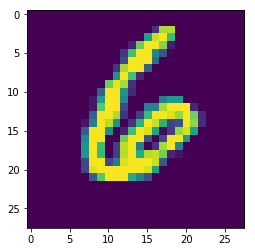

In [117]:
import matplotlib.pyplot as plt
plt.imshow(six_image[:, :, 0])
plt.show()

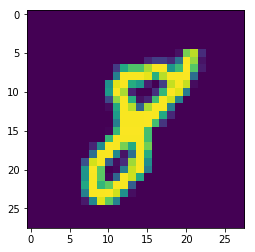

In [118]:
plt.imshow(eight_image[:, :, 0])
plt.show()

In [119]:
six_latent = encoder.predict(six_image.reshape([1, 28, 28, 1]))
six_decoded = decoder.predict(six_latent)

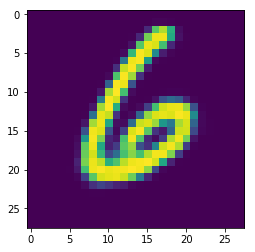

In [125]:
six_decoded = six_decoded.reshape([28, 28, 1])
plt.imshow(six_decoded[:, :, 0])
plt.show()

In [126]:
eight_latent = encoder.predict(eight_image.reshape([1, 28, 28, 1]))
eight_decoded = decoder.predict(eight_latent)


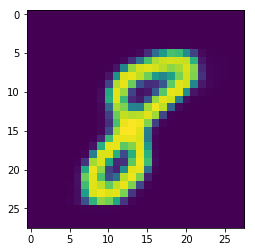

In [124]:
eight_decoded = eight_decoded.reshape([28, 28, 1])
plt.imshow(eight_decoded[:, :, 0])
plt.show()


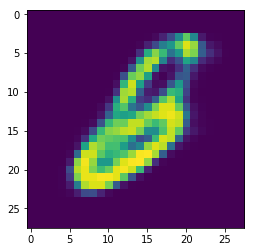

In [135]:
eight_minus_six_latent = six_latent + eight_latent

eight_minus_six_decoded = decoder.predict(eight_minus_six_latent)
eight_minus_six_decoded = eight_minus_six_decoded.reshape([28, 28, 1])
plt.imshow(eight_minus_six_decoded[:, :, 0])
plt.show()
